# Analysis of Cell-free and HIV - Figure 3

This notebook will present analyses and discussions of the GH-VAP project looking for potential microbiome causes/associations with individuals who produce broadly neutralizing antibodies to HIV; as well as everything else I can learn from the transcriptome. 

This specific notebook will handle the code to generate figure 3.

## Author: 
 **Mark Kowarsky**
 
 - **Date Updated:** 2018-10-24


#### Code cleaned by:
- Mercedes Dalman
- **Date Updated:** 2025-09

## Imports and stylings

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import HTSeq
import glob
import itertools
from collections import defaultdict
import matplotlib.dates as mdates
import os

#from wordcloud import WordCloud
from matplotlib.colors import to_hex

from ete3 import NCBITaxa#, TreeStyle, NodeStyle, faces

from IPython.core.pylabtools import figsize

from scipy.interpolate import PchipInterpolator
from scipy.stats.mstats import spearmanr

from sklearn import decomposition, manifold

from adjustText import adjust_text

import pysam

#%load_ext rpy2.ipython

In [4]:
# Colours from Material Design - https://material.io/tools/color/
green = "#388e3c"
light_green = "#6abf69"
dark_green = "#00600f"

blue = "#1976d2"
light_blue = "#63a4ff"
dark_blue = "#004ba0"

red = "#d32f2f"
light_red = "#ff6659"
dark_red = "#9a0007"

yellow = "#fbc02d"
light_yellow = "#fff263"
dark_yellow = "#c49000"

grey = "#616161"
light_grey = "#8e8e8e"
dark_grey = "#373737"

orange = "#f57c00"
light_orange = "#ffad42"
dark_orange = "#bb4d00"

purple = "#7b1fa2"
dark_purple = "#4a0072"
light_purple = "#ae52d4"

## Breadth of broadly neutralizing antibodies

In [5]:
design = pd.read_table("tables/edgeR_design.txt", index_col=0)

a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [6]:
meta1 = pd.read_excel("tables/Gates_metadata.xlsx", sheet_name=1)
meta1["sample"] = "SAMPLE_" + meta1["PID"].astype(str) + 14*["_1", "_2", "_3"]
meta1.set_index("sample", inplace=True)

## Basic statistics

In [7]:
rsa = pd.read_table("tables/samples/rSA.csv", index_col=0)
sa = pd.read_table("tables/samples/SA.csv", index_col=0)

In [8]:
pre = pd.read_table("tables/preprocess_stats.txt", index_col=0)

pre["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in pre.index]
pre = pre.groupby("group").sum()

# Non-human counts
nh = pd.read_table("tables/not_human_stats.txt", names=["sample", "type", "end", "stat"])
nh["type"] = nh["type"] + "_" + nh["end"]
nh = nh.pivot(index="sample", columns="type", values="stat")

nh["group"] = [i.strip("B") if (i.endswith("B") and i != "Water_B") else i for i in nh.index]
nh = nh.groupby("group").sum()

In [9]:
# Order of samples
a = list(design.query("bNAbs == 'Y'").index)
b = list(design.query("bNAbs == 'N'").index)
c = a + b

In [10]:
pre_rsa = pd.DataFrame(index=rsa.index, columns=["raw", "cleaned", "nonhuman"])
pre_rsa.loc[rsa.index, "raw"] = pre.loc[rsa.index, "raw_fastq.1"]
pre_rsa.loc[rsa.index, "cleaned"] = 100-\
                                    100*(pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["raw_fastq.1", "raw_fastq.U"]].sum(axis=1)
pre_rsa.loc[rsa.index, "cleaned_counts"] = (pre.loc[rsa.index, ["cleaned_fastq.1", 
                                                             "cleaned_fastq.U"]].sum(axis=1))
pre_rsa.loc[rsa.index, "nonhuman"] = 100*(nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1))/pre.loc[rsa.index, 
                                                    ["cleaned_fastq.1", "cleaned_fastq.U"]].sum(axis=1)
pre_rsa["human"] = 100 - pre_rsa["nonhuman"]
pre_rsa["human_counts"] = pre_rsa["cleaned_counts"] - nh.loc[rsa.index, ["human_genome_fastq.1", 
                                                             "human_genome_fastq.U"]].sum(axis=1)

pre_rsa = pre_rsa.sort_index()
pre_rsa["Subject"] = [i.split("_")[1] for i in pre_rsa.index]
pre_rsa["Subject"] = [i[:-1] if "water" in i else i for i in pre_rsa["Subject"]]

pre_rsa = pre_rsa.loc[c + list(rsa.index.difference(c))] # Preserve order from before

In [11]:
meta1["other_name"] = meta1["PID"].astype(str) + "_" + meta1["visit code"].astype(str)
meta1["old_name"] = meta1.index
m = meta1.set_index("other_name")

## Transcriptome

In [12]:
genes = pd.read_table("tables/gene_counts.txt", index_col=0).T

genes_duprm = genes.copy().loc[[s for s in genes.index if "duprm" in s]]
genes_duprm["sample"] = [s.split(".")[0] for s in genes_duprm.index]
genes_duprm = genes_duprm.groupby("sample").sum().T

genes = genes.copy().loc[[s for s in genes.index if "duprm" not in s]]
genes["sample"] = [s.split(".")[0] for s in genes.index]
genes = genes.groupby("sample").sum().T

In [13]:
just_genes = genes.iloc[:-5]
just_genes = genes.loc[[g for g in genes.index if "ENSG" in g]]
cpm = (1e6*just_genes.div(just_genes.sum()))
logCPM = np.log10(cpm+1)

X = logCPM.loc[:, meta1.index.difference(["SAMPLE_100200_1"])].T

In [14]:
#just_genes.loc[:, X.index].to_csv("just_gene_counts.txt", sep="\t") # Just good samples here

# Correlations with Clinical Outcomes

In [14]:
# Load gene names and HIV associated genes
ensembl = pd.read_table("tables/ensembl.tsv", index_col=0)
ensembl_clean = ensembl[ensembl["Gene name"].apply(lambda s: len(s.split("-"))) == 1]

hiv_genes = pd.read_excel("tables/MalaCards-HIV.xlsx", index_col=0)
hiv_genes["gene"] = hiv_genes["Symbol"].apply(lambda s: s.split()[0])
hiv_genes.index = hiv_genes["gene"]
hiv_ensembl = [g for g in ensembl.index if ensembl.loc[g, "Gene name"] in hiv_genes["gene"].values]

In [15]:
clin_gene_corr = pd.read_table("tables/clinicalmeasurements_gene_correlations.txt", index_col=0)

In [16]:
clin_num_correlated = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() > 0).sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05].dropna() < 0).sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() > 0).sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01].dropna() < 0).sum()
    clin_num_correlated.loc[c] = u5, d5, u1, d1

In [17]:
clin_num_correlated_HIV = pd.DataFrame(index=["cfHIV", "viralload", "CD4"], columns=["u5", "d5", "u1", "d1"])
for c in clin_num_correlated_HIV.index:
    u5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] > 0).reindex(hiv_ensembl).dropna().sum()
    d5 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.05] < 0).reindex(hiv_ensembl).dropna().sum()
    u1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] > 0).reindex(hiv_ensembl).dropna().sum()
    d1 = (clin_gene_corr[c][clin_gene_corr[c+"_p"] <= 0.01] < 0).reindex(hiv_ensembl).dropna().sum()
    clin_num_correlated_HIV.loc[c] = u5, d5, u1, d1

# Panel A

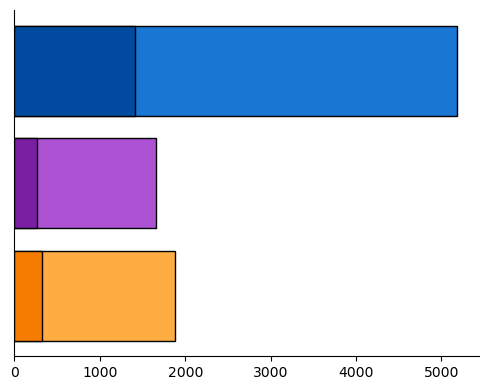

In [18]:
figsize(6, 4.5)
plt.barh(y=2, width=clin_num_correlated.loc["cfHIV", "u5"]+clin_num_correlated.loc["cfHIV", "d5"],
         color=blue, linewidth=1, edgecolor="k")

plt.barh(y=2, width=clin_num_correlated.loc["cfHIV", "u1"]+clin_num_correlated.loc["cfHIV", "d1"], 
         color=dark_blue, linewidth=1, edgecolor="k")

plt.barh(y=1, width=clin_num_correlated.loc["viralload", "u5"]+clin_num_correlated.loc["viralload", "d5"],
         color=light_purple, linewidth=1, edgecolor="k")

plt.barh(y=1, width=clin_num_correlated.loc["viralload", "u1"]+clin_num_correlated.loc["viralload", "d1"], 
         color=purple, linewidth=1, edgecolor="k")

plt.barh(y=0, width=clin_num_correlated.loc["CD4", "u5"]+clin_num_correlated.loc["CD4", "d5"],
         color=light_orange,linewidth=1, edgecolor="k")

plt.barh(y=0, width=clin_num_correlated.loc["CD4", "u1"]+clin_num_correlated.loc["CD4", "d1"],
         color=orange, linewidth=1, edgecolor="k")

#plt.xticks([-2000, -1000, 0, 1000, 2000], [2000, 1000, 0, 1000, 2000])
#plt.xscale("symlog", linthreshx=10)
plt.yticks([])
sns.despine()
os.makedirs('figures/figure3/panel_A/', exist_ok = True)
plt.savefig("figures/figure3/panel_A/correlation_barcharts.svg")

# Panel B

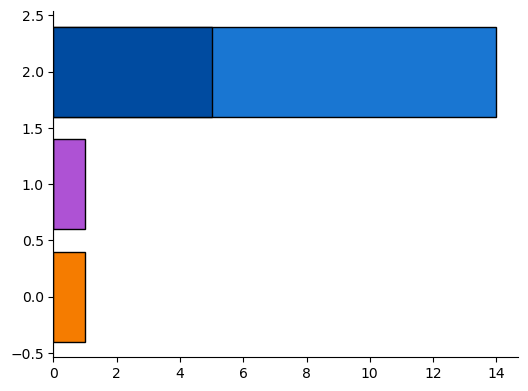

In [19]:
figsize(6, 4.5)

plt.barh(y=2, width=clin_num_correlated_HIV.loc["cfHIV", "u5"], color=blue, linewidth=1, edgecolor="k")
plt.barh(y=2, width=clin_num_correlated_HIV.loc["cfHIV", "u1"], color=dark_blue, linewidth=1, edgecolor="k")

plt.barh(y=1, width=clin_num_correlated_HIV.loc["viralload", "u5"], color=light_purple, linewidth=1, edgecolor="k")
plt.barh(y=1, width=clin_num_correlated_HIV.loc["viralload", "u1"], color=purple, linewidth=1, edgecolor="k")

plt.barh(y=0, width=clin_num_correlated_HIV.loc["CD4", "u5"], color=light_orange)
plt.barh(y=0, width=clin_num_correlated_HIV.loc["CD4", "u1"], color=orange, linewidth=1, edgecolor="k")

plt.axvline(x=0, color="k")
#plt.xticks([-2000, -1000, 0, 1000, 2000], [2000, 1000, 0, 1000, 2000])
#plt.xscale("symlog", linthreshx=10)
sns.despine()
os.makedirs('figures/figure3/panel_B', exist_ok=True)
plt.savefig("figures/figure3/panel_B/correlation_HIV_barcharts.svg")

# Panel C

In [20]:
meta1 = pd.read_csv('tables/metadata.csv', index_col = 0)


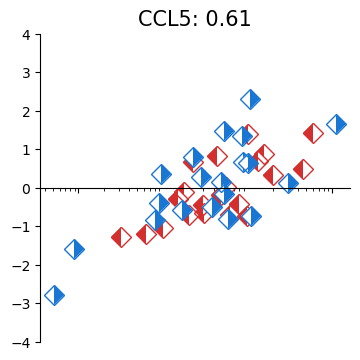

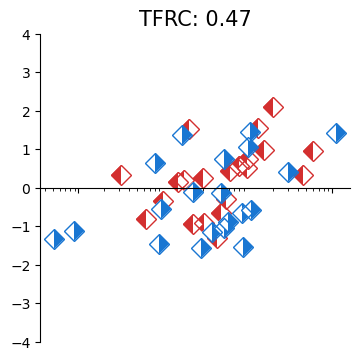

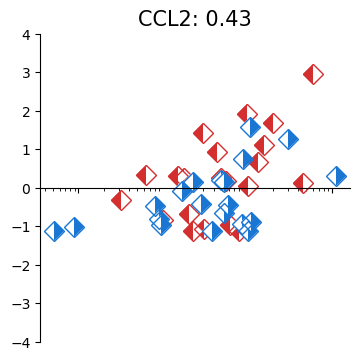

In [21]:
# Scatter plots of most correlated (HIV) genes
top_correlated_cfHIV = clin_gene_corr.query("cfHIV_p <= 0.05").reindex(hiv_ensembl).dropna()
top_correlated_cfHIV = top_correlated_cfHIV[top_correlated_cfHIV['Gene name'].isin(['CCL5','TFRC','CCL2'])].copy()

figsize(4, 4)
for g in top_correlated_cfHIV.sort_values(by="cfHIV", ascending=False).index:
    x = meta1.loc[X.index, "cfHIV"]
    y = logCPM.loc[g, X.index]
    y -= y.mean()
    y /= y.std() # z-score of gene expression

    # Different colours and styles for the two groups
    i = design.loc[x.index].query("bNAbs == 'Y'").index
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="left", markersize = 10)
    plt.plot(x.loc[i], y.loc[i], color=red, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none", markersize = 10)
    i = design.loc[x.index].query("bNAbs == 'N'").index
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=0, fillstyle="right", markersize = 10)
    plt.plot(x.loc[i], y.loc[i], color=blue, marker="D", 
             markerfacecoloralt="white", linewidth=0, markeredgewidth=1, fillstyle="none", markersize = 10)
    plt.ylim(-4, 4)
    plt.xscale("log")
    plt.title("{}: {:.2f}".format(ensembl.loc[g, "Gene name"], clin_gene_corr.loc[g, "cfHIV"]), fontsize = 15)
    
    ax = plt.gca()
    ax.spines['bottom'].set_position('center')
    plt.xticks([0.1, 100], ["", ""])
 
    sns.despine()
    
    os.makedirs('figures/figure3/panel_C/', exist_ok = True)
    plt.savefig("figures/figure3/panel_C/{}.svg".format(ensembl.loc[g, "Gene name"]))
    plt.show()